# Cargue ,Preparación y Transformación de datos (Modelo RFM)

### Julián Ramírez, Ph.D - www.julianramirez.co - Todos los derechos reservados - Material con fines educativos únicamente

En este *notebook* trabajaremos con un archivo transaccional de ejemplo que contiene datos de uso de la aplicación Cabify en la ciudad de Lima (Perú) para el año 2010.

Este archivo ilustra un primer módulo que contiene las siguientes tareas:

+ Importar datos almacenados en el servidor en nube
+ Depurar la base de datos considerando algunas reglas de negocio puntuales
+ Agregar datos de usuarios y conductores y separar en *datasets*
+ Utilizar los *datasets* obtenidos en el paso anterior para construir un modelo RFM de valoración de clientes (y de paso, de conductores)


### Cargando los datos

Nuestro primer paso consiste en conectar el archivo que contiene los datos para nuestro ejercicio. 
Este archivo está almacenado en IBM Cloud, por lo que se requiere una conexión que emplea el paquete aws.s3 y trae el objeto utilizando datos de acceso.
El archivo original era un archivo en formato .csv.

In [6]:
library("aws.s3")
obj <- get_object(
    object = "CabifyCSV.csv",
    bucket = "businessanalyticscourse-donotdelete-pr-dc14skeq3r3biq",
    key = "7fef7621122c4cac8c0f9f261f49574f",
    secret = "19f12a7a2ee4a2d1562af7362c9393aca28eed23f2bca20a",
    check_region = FALSE,
    base_url = "s3-api.us-geo.objectstorage.service.networklayer.com")

Como resultado de esta conexión, se produce un archivo raw, por lo que se hace esencial convertirlo en un archivo plano 

In [7]:
dataset <- rawToChar(obj, multiple= FALSE)

Ahora, para importarlo como un archivo delimitado por caracteres utilizamos el paquete readr. En las especificaciones, usamos la función read_delim que trae datos delimitados.
Nuestro archivo está separado por ";" por lo que en los argumentos de read_delim especificamos esta función. También aprovechamos para convertir a formato *datetime* las fechas de modo que queden adecuada para analizarlas.


In [8]:
library("readr")
cabify <- read_delim(dataset, ";", escape_double = FALSE, col_types = cols(arrived_at = col_datetime(format = "%d/%m/%Y %H:%M"), 
        end_at = col_datetime(format = "%d/%m/%Y %H:%M"), 
        start_at = col_datetime(format = "%d/%m/%Y %H:%M")), 
    trim_ws = TRUE)
head(cabify)
print("Aquí tenemos nuestro archivo listo para iniciar la fase de procesamiento")

journey_id,user_id,driver_id,taxi_id,icon,start_type,start_at,start_lat,start_lon,end_at,...,price_distance,price_duration,distance,duration,cost,cost_distance,cost_duration,source,driver_score,rider_score
23a1406fc6a11d866e3c82f22eed4d4c,0e9af5bbf1edfe591b54ecdfd7e91e26,583949a89a9ee17d19e3ca4f137b6b4c,b12f4f09c783e29fe0d0ea624530db56,executive,asap,2010-11-16 16:44:00,-1213983536,-7702355957,2010-11-16 17:29:00,...,3626,195,11331,234,0,0,0,iPhone,5,5
dd2af4715d0dc16eded53afc0e243577,a553c46e3a22fb9c326aeb3d72b3334e,NA,NA,executive,asap,2010-06-01 00:34:00,-1213874817,-7699536133,2010-06-01 00:37:00,...,NA,NA,0,0,0,NA,NA,iPhone,NA,NA
dd91e131888064bf7df3ce08f3d4b4ad,a553c46e3a22fb9c326aeb3d72b3334e,NA,NA,executive,asap,2010-05-31 05:01:00,-1212453079,-7702780151,2010-05-31 05:04:00,...,NA,NA,0,0,0,NA,NA,iPhone,NA,NA
dd2af4715d0dc16eded53afc0e2466d0,a553c46e3a22fb9c326aeb3d72b3334e,NA,NA,executive,asap,2010-06-01 00:29:00,-1213885117,-7699530029,2010-06-01 00:32:00,...,NA,NA,0,0,0,NA,NA,iPhone,NA,NA
85b7eabcf5d84e42dc7629b7d27781af,56772d544fdfa589a020a1ff894a86f7,d665fb9f75ef5d9cd0fd89479380ba78,0accdd3aa5a322f4129fa20b53278c69,executive,reserved,2010-09-11 23:55:00,-1208995438,-7692626953,2010-09-12 01:07:00,...,7665,562,30270,715,6173,5756,417,iPhone,4,5
2254715f0f569e3173ec61f16cbb8341,56772d544fdfa589a020a1ff894a86f7,baacf396f773709519bbde35a5eab861,baacf396f773709519bbde35a585d91b,executive,reserved,2010-08-10 13:00:00,-1202241898,-7710650635,2010-08-10 14:26:00,...,7393,1001,29080,1201,5875,5175,700,iPhone,NA,4


[1] "Aquí tenemos nuestro archivo listo para iniciar la fase de procesamiento"


### Procesamiento de los datos

Nuestra primera tarea en el procesamiento consiste en convertir las variables que están almacenadas como texto y aportan información relevante como factores. 
En este caso, tenemos cuatro variables que cumplen este propósito:

+ Icon: que es una variable que almacena el tipo de servicio que el usuario ha seleccionado en Cabify: *executive, group o easy*.
+ Start_type: que es una variable que almacena el tipo de inicio del servicio: *asap, delayed o reserved*
+ End_state: que es una variable que contiene las causas de finalización de un servicio: *drop off, failure, no show, not found o rider cancel*.
+ Source: que es una variable que especifica el sistema operativo o plataforma del dispositivo desde el cual fue solicitado el servicio: *Android, iPad, iPhone, Wap o web*.

In [9]:
cabify$icon <- as.factor(cabify$icon)
cabify$start_type <- as.factor(cabify$start_type)
cabify$end_state <- as.factor(cabify$end_state)
cabify$source <- as.factor(cabify$source)

Ahora, vamos a generar un resumen de algunas estadísticas descriptivas sobre las variables, que nos permitirán establecer si algunas de ellas presentan potenciales problemas con el cumplimiento de reglas de negocio. Como resultado, extraeremos una lista de variables que puedan representar situaciones problemáticas en las etapas posteriores del análisis

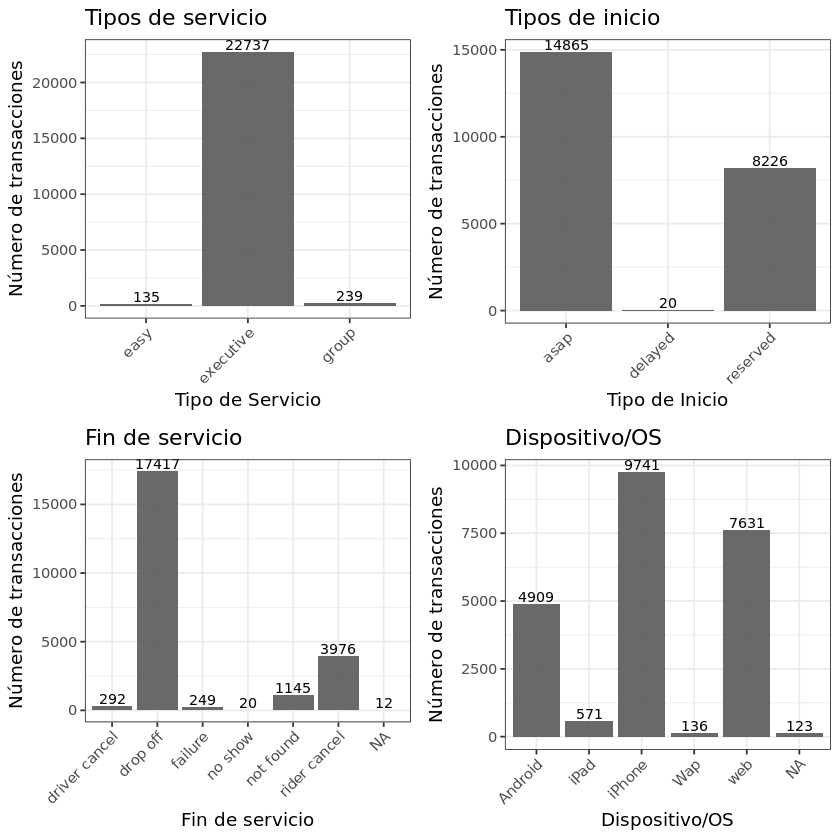

In [10]:
#se crean cuatro objetos llamados g1, g2, g3 y g4. En cada uno de estos objetos se construye una gráfica por cada factor. Luego, la función *grid.arrange* del paquete *gridExtra* los agrupará en una matriz de 2x2.
#También se estableció un tema del paquete ggplot2 que se denomina *theme_bw()* para dar formato a los gráficos.
library(ggplot2)
library(gridExtra)
theme_set(theme_bw())
g1 <- ggplot(data=cabify,aes(x =icon)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Tipo de Servicio",y ="Número de transacciones",title= "Tipos de servicio") + geom_text(size=3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g2 <- ggplot(data=cabify,aes(x =start_type)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Tipo de Inicio",y ="Número de transacciones",title= "Tipos de inicio") + geom_text(size = 3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g3 <- ggplot(data=cabify,aes(x =end_state)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Fin de servicio",y ="Número de transacciones",title= "Fin de servicio") + geom_text(size = 3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g4 <- ggplot(data=cabify,aes(x =source)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Dispositivo/OS",y ="Número de transacciones",title= "Dispositivo/OS") + geom_text(size=3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
grid.arrange(g1,g2,g3,g4, nrow=2)

Los gráficos obtenidos nos permiten apreciar la alta concentración de transacciones del servicio "Executive", un muy pequeño de transacciones que tienen tipo de inicio "delayed", que la mayor parte de transacciones terminan exitosamente con la recogida del pasajero (drop off) y que los dispositivos móviles, junto con el acceso via web, son los dispositivos preferidos. Con base en esto, para nuestro análisis aplicaremos las siguientes reglas acordadas con el negocio:

+ Solo se tendrán en cuenta servicios tipo "executive"
+ Se eliminaran las transacciones que iniciaron como "delayed"
+ Solo se incluirán los servicios que terminaron con recogida exitosa "drop off"
+ No se tendrán en cuenta servicios solicitados por iPad, Wap o cuya fuente es N/A


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] "Total de casos en el archivo:"


[1] 16580

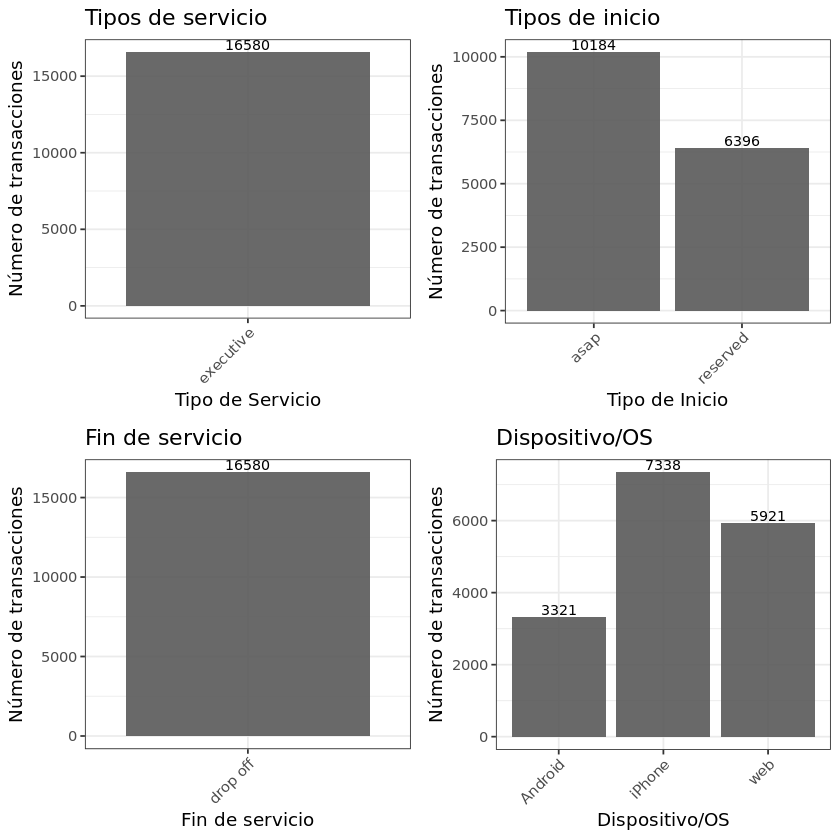

In [11]:
# Debemos primero activar la librería *dplyr*. Copiaremos el resultado del filtro en un nuevo subconjunto llamado cabifyR1, con el ánimo de no arruinar la fuente de datos original. 
# Posteriormente, solicitaremos que nos confirme el número de registros finales después de aplicar el filtro, y repetiremos las gráficas solo para confirmar
library(dplyr)
cabifyR1 <- filter(cabify, icon=='executive')
cabifyR1 <- filter(cabifyR1, start_type !='delayed')
cabifyR1 <- filter(cabifyR1, end_state=='drop off')
cabifyR1 <- filter(cabifyR1, source=='Android'| source=='iPhone' | source=='web')
print("Total de casos en el archivo:")
nrow(cabifyR1)
g1 <- ggplot(data=cabifyR1,aes(x =icon)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Tipo de Servicio",y ="Número de transacciones",title= "Tipos de servicio") + geom_text(size=3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g2 <- ggplot(data=cabifyR1,aes(x =start_type)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Tipo de Inicio",y ="Número de transacciones",title= "Tipos de inicio") + geom_text(size = 3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g3 <- ggplot(data=cabifyR1,aes(x =end_state)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Fin de servicio",y ="Número de transacciones",title= "Fin de servicio") + geom_text(size = 3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g4 <- ggplot(data=cabifyR1,aes(x =source)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Dispositivo/OS",y ="Número de transacciones",title= "Dispositivo/OS") + geom_text(size=3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
grid.arrange(g1,g2,g3,g4, nrow=2)

Una vez hemos verificado que la primera depuración sobre reglas de negocio, iniciaremos el segundo lote del análisis exploratorio, el cual nos permitirá revisar las variables escalares disponibles en busca de valores atípicos. 

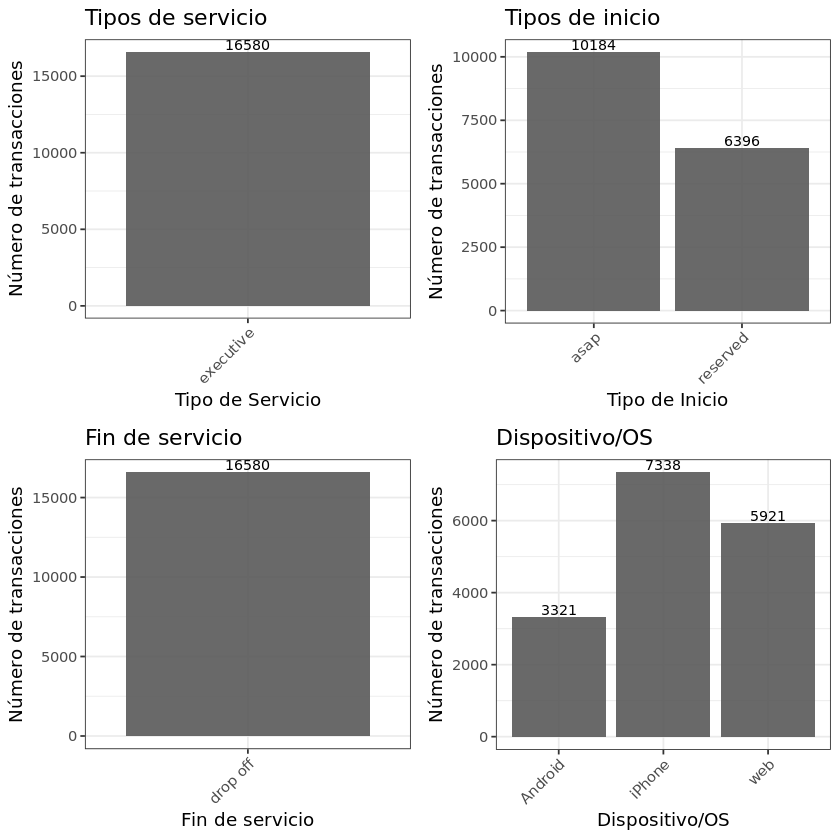

In [12]:
g1 <- ggplot(data=cabifyR1,aes(x =icon)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Tipo de Servicio",y ="Número de transacciones",title= "Tipos de servicio") + geom_text(size=3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g2 <- ggplot(data=cabifyR1,aes(x =start_type)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Tipo de Inicio",y ="Número de transacciones",title= "Tipos de inicio") + geom_text(size = 3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g3 <- ggplot(data=cabifyR1,aes(x =end_state)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Fin de servicio",y ="Número de transacciones",title= "Fin de servicio") + geom_text(size = 3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
g4 <- ggplot(data=cabifyR1,aes(x =source)) + geom_bar( position ="stack",alpha=0.9) + labs(x ="Dispositivo/OS",y ="Número de transacciones",title= "Dispositivo/OS") + geom_text(size=3, stat = 'count',aes(label =..count.., vjust = -0.2)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))
grid.arrange(g1,g2,g3,g4, nrow=2)

In [28]:
descriptivos <- summary(cabifyR1$price)
Cabifyexp <- as.data.frame(rbind(names(descriptivos), as.numeric(descriptivos)))
print(Cabifyexp)

    V1      V2     V3               V4      V5    V6   V7
1 Min. 1st Qu. Median             Mean 3rd Qu.  Max. NA's
2    0    1700   2523 3498.99101055807    4230 55974    5
